# Constructing a DFA object from LTLf specification

In [1]:
from pythomata import SymbolicAutomaton
from pythomata.simulator import AutomatonSimulator
from ltlf2dfa.parser.ltlf import LTLfParser
import graphviz
import pygraphviz

((F((a & F((b & F(c))))) & G(!(u))) | e)


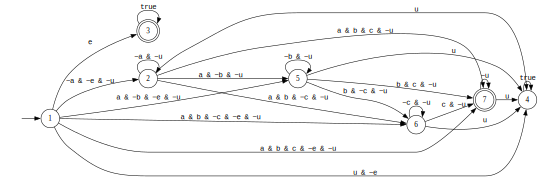

In [2]:
parser = LTLfParser()

# Sequential reachability problem (A -> B -> C while avoiding U), assuming that we can't enter multiple goals at the same time

# The issue with the 'simple' formula is that it doesn't understand that you cannot enter multiple goals at the same time
# It includes transitions for all possible cases of reaching more than one goal in the same time-step
# For modular Rl methods this is fine since the agent learns a policy for each state, not each transition
# However this isn't good for our purposes since it means the agent will try to learn a bunch of extra policies for impossible tasks
formula_str = "(F (a & F (b & F (c ))) & G ~u) | e"
formula = parser(formula_str)

print(formula)

dfa_str = formula.to_dfa()  # DFA as a string, in DOT format (suitable for Graphviz)
dfa_viz = graphviz.Source(dfa_str, format="png")
dfa_viz

In [3]:
# Unfortunately, the constructed DFA is a string in DOT format
# However, we want an actual DFA object (e.g. from pythomata, but I suppose we could use any FSM library)
print(dfa_str)

digraph MONA_DFA {
 rankdir = LR;
 center = true;
 size = "7.5,10.5";
 edge [fontname = Courier];
 node [height = .5, width = .5];
 node [shape = doublecircle]; 3; 7;
 node [shape = circle]; 1;
 init [shape = plaintext, label = ""];
 init -> 1;
 1 -> 2 [label="~a & ~e & ~u"];
 1 -> 3 [label="e"];
 1 -> 4 [label="u & ~e"];
 1 -> 5 [label="a & ~b & ~e & ~u"];
 1 -> 6 [label="a & b & ~c & ~e & ~u"];
 1 -> 7 [label="a & b & c & ~e & ~u"];
 2 -> 2 [label="~a & ~u"];
 2 -> 4 [label="u"];
 2 -> 5 [label="a & ~b & ~u"];
 2 -> 6 [label="a & b & ~c & ~u"];
 2 -> 7 [label="a & b & c & ~u"];
 3 -> 3 [label="true"];
 4 -> 4 [label="true"];
 5 -> 5 [label="~b & ~u"];
 5 -> 4 [label="u"];
 5 -> 6 [label="b & ~c & ~u"];
 5 -> 7 [label="b & c & ~u"];
 6 -> 6 [label="~c & ~u"];
 6 -> 4 [label="u"];
 6 -> 7 [label="c & ~u"];
 7 -> 7 [label="~u"];
 7 -> 4 [label="u"];
}


In [4]:
# We need to parse the string and construct a DFA from the extracted information
def construct_dfa_from_str(dfa_str: str):

    # Parse the DOT string
    graph = pygraphviz.AGraph(dfa_str)

    states = set()
    transitions = set()
    initial_state = None
    final_states = set()

    # Extract states (and final states)
    for node in graph.nodes():
        if node == "init":
            continue
        states.add(int(node))
        if node.attr["shape"] == "doublecircle":
            final_states.add(int(node))

    # Extract transitions (and initial state)
    for edge in graph.edges():
        label = edge.attr["label"]
        if edge[0] == "init":
            initial_state = int(edge[1])
            continue
        transitions.add((int(edge[0]), label, int(edge[1])))

    # Construct a SymbolicAutomaton
    automaton = SymbolicAutomaton()._from_transitions(
        states=states,
        initial_state=initial_state,
        final_states=final_states,
        transitions=transitions,
    )

    # Minimize and determinize the automaton (not required since LTLf2DFA already does this)
    # automaton = automaton.minimize()
    # automaton = automaton.determinize()

    return automaton

5
<class 'pythomata.impl.symbolic.SymbolicDFA'>


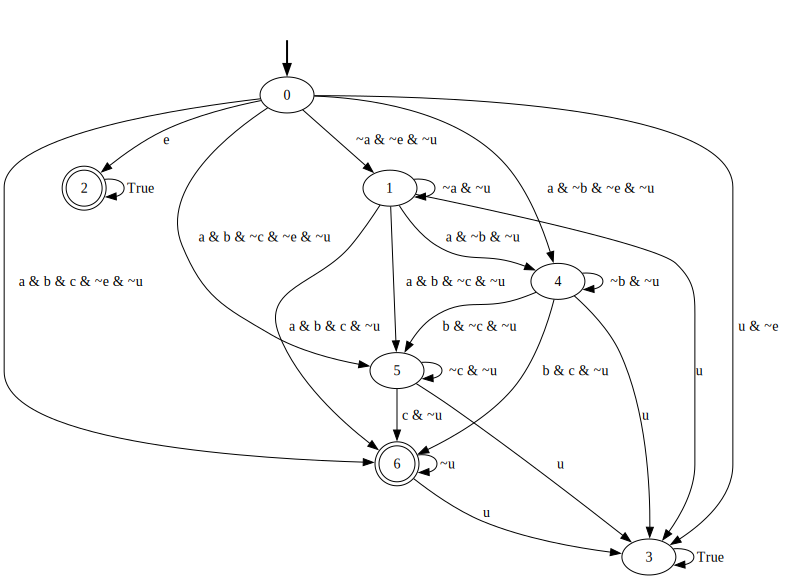

In [5]:
automaton = construct_dfa_from_str(dfa_str)
print(automaton.get_successor(4, {"b": True}))
print(type(automaton))

automaton_viz = automaton.to_graphviz()
automaton_viz

In [6]:
# High-level function to convert LTLf formula string to a simulated DFA object
def ltlf_to_dfa(formula_str: str):
    formula = parser(formula_str)
    dfa_str = formula.to_dfa()
    return AutomatonSimulator(construct_dfa_from_str(dfa_str))

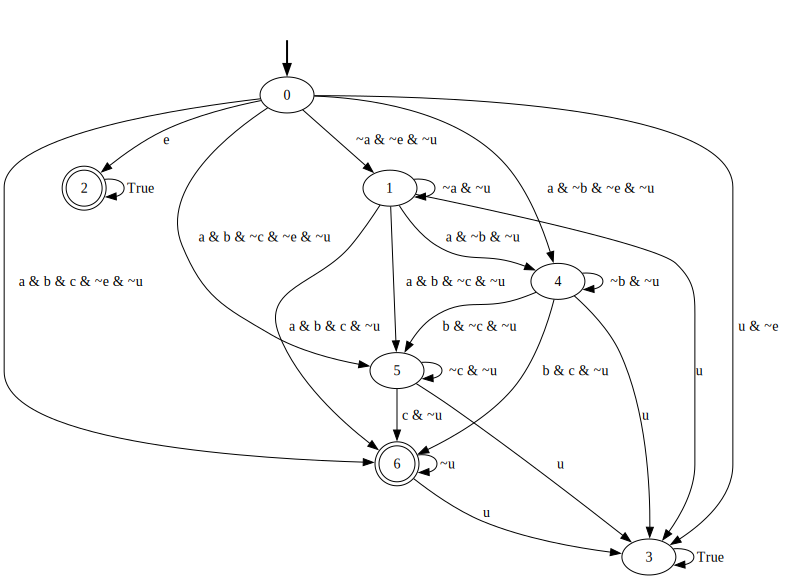

In [7]:
formula_str = "(F (a & F (b & F (c ))) & G ~u) | e"
sim_automaton = ltlf_to_dfa(formula_str)

automaton_viz = sim_automaton.automaton.to_graphviz()
automaton_viz

In [8]:
print(sim_automaton.automaton.get_transitions_from(4))

{(4, u, 3), (4, b & c & ~u, 6), (4, b & ~c & ~u, 5), (4, ~b & ~u, 4)}


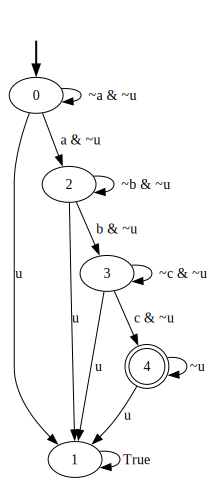

In [9]:
# Including the 'X' operator in the formula implies that we can't do multiple sub-tasks in the same time-step
# This is because the 'X' operator specifies that the sub-tasks must be done one after the other
# As a result, the DFA becomes much neater!
formula_str = "(F (a & X F (b & X F (c ))) & G ~u)"
sim_automaton = ltlf_to_dfa(formula_str)

automaton_viz = sim_automaton.automaton.to_graphviz()
automaton_viz